# Importing Necessary Libraries

In [10]:
!pip install xgboost imbalanced-learn
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
from imblearn.over_sampling import SMOTE

# Loading the dataset

In [11]:
df_train = pd.read_csv('fraudTrain.csv')
df_test = pd.read_csv('fraudTest.csv')
df_train.drop(columns = ["Unnamed: 0", "cc_num", "first", "last", "street", "trans_num"],inplace = True,errors = 'ignore')
df_test.drop(columns = ["Unnamed: 0", "cc_num", "first", "last", "street", "trans_num"],inplace = True,errors = 'ignore')


# Convert date column to useful features

In [12]:
# for the training set
df_train['trans_date_trans_time'] = pd.to_datetime(df_train['trans_date_trans_time'])
df_train['hour'] = df_train['trans_date_trans_time'].dt.hour
df_train['day_of_week'] = df_train['trans_date_trans_time'].dt.dayofweek
df_train['is_weekend'] = (df_train['day_of_week'] >=5).astype(int)
df_train.drop(columns=['trans_date_trans_time'], inplace=True)

# for the test set
df_test['trans_date_trans_time'] = pd.to_datetime(df_test['trans_date_trans_time'])
df_test['hour'] = df_test['trans_date_trans_time'].dt.hour
df_test['day_of_week'] = df_test['trans_date_trans_time'].dt.dayofweek
df_test['is_weekend'] = (df_test['day_of_week'] >=5).astype(int)
df_test.drop(columns=['trans_date_trans_time'], inplace=True)

# Encoding the categorical variables

In [13]:
cat_var = df_train.select_dtypes(include = ['object']).columns
df_train[cat_var] = df_train[cat_var].apply(lambda col: LabelEncoder().fit_transform(col))
df_test[cat_var] = df_test[cat_var].apply(lambda col: LabelEncoder().fit_transform(col))
print(df_train.head(3))

   merchant  category     amt  gender  city  state    zip      lat      long  \
0       514         8    4.97       0   526     27  28654  36.0788  -81.1781   
1       241         4  107.23       0   612     47  99160  48.8878 -118.2105   
2       390         0  220.11       1   468     13  83252  42.1808 -112.2620   

   city_pop  job  dob   unix_time  merch_lat  merch_long  is_fraud  hour  \
0      3495  370  779  1325376018  36.011293  -82.048315         0     0   
1       149  428  607  1325376044  49.159047 -118.186462         0     0   
2      4154  307  302  1325376051  43.150704 -112.154481         0     0   

   day_of_week  is_weekend  
0            1           0  
1            1           0  
2            1           0  


# Specifying the training and test data as input and output data

In [14]:
X_train = df_train.drop('is_fraud', axis=1)
y_train = df_train['is_fraud']
X_test = df_test.drop('is_fraud', axis=1)
y_test = df_test['is_fraud']
print(X_train)
print(y_train)

         merchant  category     amt  gender  city  state    zip      lat  \
0             514         8    4.97       0   526     27  28654  36.0788   
1             241         4  107.23       0   612     47  99160  48.8878   
2             390         0  220.11       1   468     13  83252  42.1808   
3             360         2   45.00       1    84     26  59632  46.2306   
4             297         9   41.96       1   216     45  24433  38.4207   
...           ...       ...     ...     ...   ...    ...    ...      ...   
1296670       499         0   15.56       1   330     44  84735  37.7175   
1296671         2         1   51.70       1   813     20  21790  39.2667   
1296672       599         1  105.93       1   346     32  88325  32.9396   
1296673       509         1   74.90       1   471     41  57756  43.3526   
1296674       370         1    4.30       1   782     26  59871  45.8433   

             long  city_pop  job  dob   unix_time  merch_lat  merch_long  \
0        -8

# Handling Class Imbalance using SMOTE

In [15]:
smote = SMOTE(random_state = 42)
X_resampled_train,y_resampled_train = smote.fit_resample(X_train,y_train)
X_resampled_test,y_resampled_test = smote.fit_resample(X_test,y_test)

# Feature Scaling

In [16]:
scaler = StandardScaler()
X_resampled_train = scaler.fit_transform(X_resampled_train)
X_resampled_test = scaler.transform(X_resampled_test)

# Training XGBoost Classifier

In [17]:
xgb_clf = XGBClassifier(objective="binary:logistic",eval_metric="logloss",use_label_encoder=False,random_state=42)
xgb_clf.fit(X_resampled_train,y_resampled_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:46:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# Predticing using X_resampled_test

In [18]:
y_pred = xgb_clf.predict(X_resampled_test)

# Evaualtion Metrics

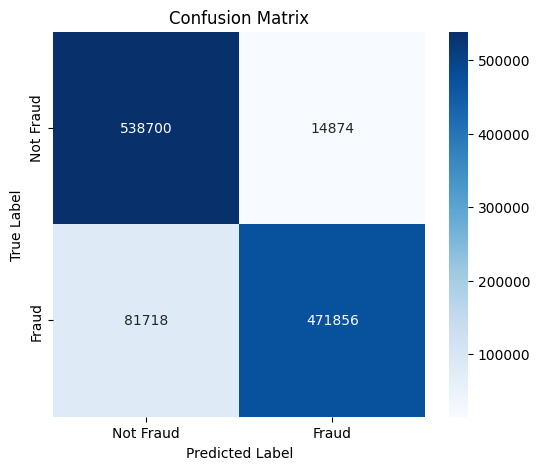


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92    553574
           1       0.97      0.85      0.91    553574

    accuracy                           0.91   1107148
   macro avg       0.92      0.91      0.91   1107148
weighted avg       0.92      0.91      0.91   1107148


ROC-AUC Score: 0.9127560181655932


In [19]:
# Compute confusion matrix
cm = confusion_matrix(y_resampled_test,y_pred)
labels = ["Not Fraud", "Fraud"]
import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(y_resampled_test,y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_resampled_test,y_pred))

# Precision-Recall Curve

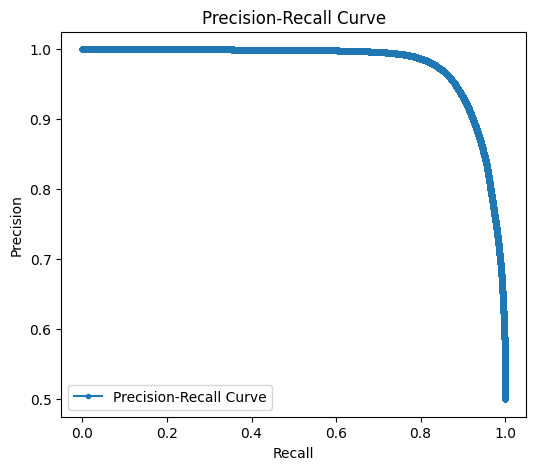

In [20]:
y_pred_probs = xgb_clf.predict_proba(X_resampled_test)[:,1]
from sklearn.metrics import precision_recall_curve
precision,recall,_ = precision_recall_curve(y_resampled_test,y_pred_probs)
plt.figure(figsize=(6,5))
plt.plot(recall,precision,marker='.',label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


# Roc Curve

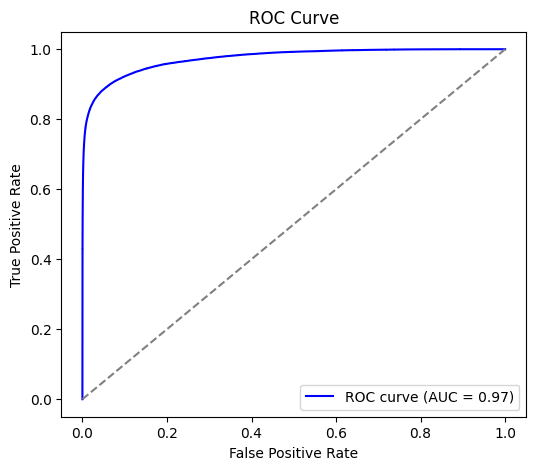

In [21]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,_ = roc_curve(y_resampled_test,y_pred_probs)
roc_auc = auc(fpr,tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr,tpr,color='blue',label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1],color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Feature Importance

<Figure size 800x600 with 0 Axes>

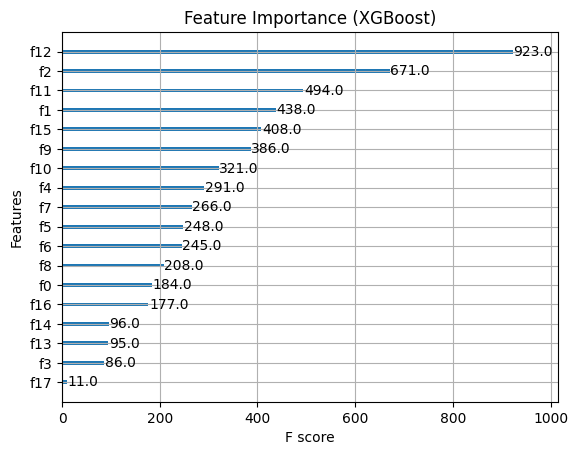

In [22]:
plt.figure(figsize=(8, 6))
xgb.plot_importance(xgb_clf)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [23]:
# Get the feature names from training data
feature_names = X_train.columns.tolist()

# Print feature names to map them to f1, f2, etc.
for i, feature in enumerate(feature_names):
    print(f"f{i}:{feature}")


f0:merchant
f1:category
f2:amt
f3:gender
f4:city
f5:state
f6:zip
f7:lat
f8:long
f9:city_pop
f10:job
f11:dob
f12:unix_time
f13:merch_lat
f14:merch_long
f15:hour
f16:day_of_week
f17:is_weekend
